In [1]:
import numpy as np
import pandas as pd
from sklearn import datasets
import torch
import torch.nn as nn
import torch.optim as optim
import torchbnn as bnn
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix 
import math
import optuna
from optuna.trial import TrialState

In [4]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data
import torchvision 

import optuna
from optuna.trial import TrialState
from torchvision import models

In [23]:
model = nn.Sequential(nn.Conv2d(1, 3, kernel_size=5), models.resnet18(pretrained=True), nn.ReLU(),nn.Linear(1000, 10))

In [24]:
n_epochs = 3
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 10

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

In [25]:
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/MNIST/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/MNIST/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=True)

In [26]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

In [27]:
example_data.shape

torch.Size([1000, 1, 28, 28])

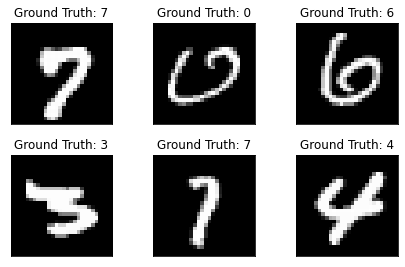

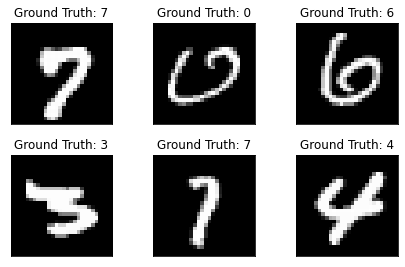

In [28]:
import matplotlib.pyplot as plt
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)
fig = plt.figure()
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    plt.title("Ground Truth: {}".format(example_targets[i]))
    plt.xticks([])
    plt.yticks([])
fig

In [29]:
# class Net(nn.Module):
#     def __init__(self):
#         super(Net, self).__init__()
#         self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
#         self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
#         self.conv2_drop = nn.Dropout2d()
#         self.fc1 = nn.Linear(320, 50)
#         self.fc2 = nn.Linear(50, 10)

#     def forward(self, x):
#         x = F.relu(F.max_pool2d(self.conv1(x), 2))
#         x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
#         x = x.view(-1, 320)
#         x = F.relu(self.fc1(x))
#         x = F.dropout(x, training=self.training)
#         x = self.fc2(x)
#         return F.log_softmax(x)

In [30]:
# layers = []
# in_features = 1
# layers.append(bnn.BayesConv2d(0, 0.1, 1, 10, kernel_size=5))
# layers.append(nn.ReLU())
# layers.append(nn.MaxPool2d(2, 2))
# layers.append(bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=in_features, out_features=20))
# layers.append(nn.ReLU())
# layers.append(bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=in_features, out_features=20))
# model = nn.Sequential(*layers)

In [31]:
# model = Net()
model

Sequential(
  (0): Conv2d(1, 3, kernel_size=(5, 5), stride=(1, 1))
  (1): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d

In [15]:
# Convert Conv2d -> BayesConv2d
from torchhk import transform_model
transform_model(model, nn.Conv2d, bnn.BayesConv2d, 
                args={"prior_mu":0, "prior_sigma":0.01, "in_channels" : ".in_channels",
                      "out_channels" : ".out_channels", "kernel_size" : ".kernel_size",
                      "stride" : ".stride", "padding" : ".padding", "bias":".bias"
                     }, 
                attrs={"weight_mu" : ".weight"})
# Convert Linear -> BayesLinear
transform_model(model, nn.Linear, bnn.BayesLinear, 
            args={"prior_mu":0, "prior_sigma":0.01, "in_features" : ".in_features",
                  "out_features" : ".out_features", "bias":".bias"
                 }, 
            attrs={"weight_mu" : ".weight"})

C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\torchhk\transform.py:34: Warning: 
 * Caution : The Input Model is CHANGED because inplace=True.
  warnings.warn("\n * Caution : The Input Model is CHANGED because inplace=True.", Warning)


Sequential(
  (0): BayesConv2d(0, 0.01, 1, 3, kernel_size=(5, 5), stride=(1, 1))
  (1): ResNet(
    (conv1): BayesConv2d(0, 0.01, 3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): BayesConv2d(0, 0.01, 64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): BayesConv2d(0, 0.01, 64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): BayesConv2d(0, 0.01, 64, 64, kernel_size=(3, 3),

In [32]:
model

Sequential(
  (0): Conv2d(1, 3, kernel_size=(5, 5), stride=(1, 1))
  (1): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d

In [33]:
ce_loss = nn.CrossEntropyLoss()
klloss = bnn.BKLLoss(reduction='mean', last_layer_only=False)
klweight = 0.01

optimizer = optim.SGD(model.parameters(), lr=0.01,
                      momentum=momentum)

In [34]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

In [35]:
def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)
        loss_1 = F.nll_loss(output, target)
        kl = klloss(model)
        total_cost = loss_1 + klweight*kl
        
        total_cost.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
            epoch, batch_idx * len(data), len(train_loader.dataset),
            100. * batch_idx / len(train_loader), total_cost.item()))
            train_losses.append(total_cost.item())
            train_counter.append(
            (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
#             print("loss_1", loss_1)
#             print("kl", kl)

In [36]:
def test():
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = model(data)
            kl = klloss(model)
            test_loss += (F.nll_loss(output, target, size_average=False).item() + klweight*kl)
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()
    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)
#     print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
#     test_loss, correct, len(test_loader.dataset),
#     100 * correct / len(test_loader.dataset)))
    print("AVG loss", test_loss)
    print("Correct", correct)
    print("Accuracy", correct/len(test_loader.dataset))

In [37]:
n_epochs = 2
test()
for epoch in range(1, n_epochs + 1):
    train(epoch)
    test()


AVG loss tensor([0.4922])
Correct tensor(119)
Accuracy tensor(0.0119)
Train Epoch: 1 [0/60000 (0%)]	Loss: 0.633897
Train Epoch: 1 [640/60000 (1%)]	Loss: -165.802475


KeyboardInterrupt: 

In [ ]:
test()

In [ ]:
test()

In [33]:
# # Convert Conv2d -> BayesConv2d
# from torchhk import transform_model
# transform_model(model, nn.Conv2d, bnn.BayesConv2d, 
#                 args={"prior_mu":0, "prior_sigma":0.01, "in_channels" : ".in_channels",
#                       "out_channels" : ".out_channels", "kernel_size" : ".kernel_size",
#                       "stride" : ".stride", "padding" : ".padding", "bias":".bias"
#                      }, 
#                 attrs={"weight_mu" : ".weight"})
# # Convert Linear -> BayesLinear
# transform_model(model, nn.Linear, bnn.BayesLinear, 
#             args={"prior_mu":0, "prior_sigma":0.01, "in_features" : ".in_features",
#                   "out_features" : ".out_features", "bias":".bias"
#                  }, 
#             attrs={"weight_mu" : ".weight"})

In [552]:

# # Convert BayesConv2d -> Conv2d
# transform_model(model, bnn.BayesConv2d, nn.Conv2d,
#                 args={"in_channels" : ".in_channels", "out_channels" : ".out_channels",
#                       "kernel_size" : ".kernel_size",
#                       "padding" : ".padding", "bias":".bias"
#                      }, 
#                 attrs={"weight" : ".weight_mu"})
# # Convert BayesLinear -> Linear
# transform_model(model, bnn.BayesLinear, nn.Linear, 
#             args={"in_features" : ".in_features", "out_features" : ".out_features",
#                   "bias":".bias"
#                  }, 
#             attrs={"weight" : ".weight_mu"})

In [34]:
def class_prob(img, iterations):
    pre_list = []
    prob_list = []
    for i in range(iterations):
        output = model(img)
        prob_list.append(F.softmax(output[0], dim=0).tolist())
        pred = output.data.max(1, keepdim=True)[1][0][0].item()
        pre_list.append(pred)
    return set(pre_list), pd.DataFrame.from_records(prob_list).transpose()

In [35]:
def mean_std(dataframe_prob):
    dataframe_prob['mean'] = dataframe_prob.iloc[:, 0:].mean(axis=1)
    dataframe_prob['std'] = dataframe_prob.iloc[:, 0:-1].std(axis=1)
    return dataframe_prob, dataframe_prob['mean'], dataframe_prob['std']

In [36]:
predictions, prob_df = class_prob(example_data[4].unsqueeze(0), 1000)

<ipython-input-8-6c2218f37724>:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


In [37]:
df, df_mean, df_std = mean_std(prob_df)

In [38]:
 df_mean, df_std

(0    3.360779e-06
 1    5.351519e-03
 2    5.073139e-03
 3    3.419049e-03
 4    1.404460e-06
 5    1.395223e-07
 6    4.451798e-09
 7    9.850267e-01
 8    4.556356e-04
 9    6.690767e-04
 Name: mean, dtype: float64,
 0    2.082647e-06
 1    3.355598e-03
 2    2.921047e-03
 3    1.656405e-03
 4    8.495628e-07
 5    9.604944e-08
 6    3.825453e-09
 7    7.077092e-03
 8    2.589609e-04
 9    3.331256e-04
 Name: std, dtype: float64)

In [44]:

pre = []
list_multiple_sol = []
multiple_predictions_list = []

std_sol = []
std_multiple_sol = []

mean_sol = []
mean_multiple_sol = []

all_pre =[]
all_mean =[]
all_var =[]
for i in range(200):
    
    predictions, prob_df = class_prob(example_data[i].unsqueeze(0), 100)
    predictions_list = list(predictions)
    
    if len(predictions_list)>1:
        print("multiple solutions in", i)
        list_multiple_sol.append(i)
        multiple_predictions_list.append(predictions_list)
        all_pre.append(predictions_list)
        
        std_sol.append(0)
        mean_sol.append(10)
        pre.append(10)
        
        std_saver = []
        mean_saver = []
        for m in predictions_list:
            df_mean_std, df_mean, df_std = mean_std(prob_df)
            std_saver.append(df_std[m])
            mean_saver.append(df_mean[m])
        std_multiple_sol.append(std_saver)
        mean_multiple_sol.append(mean_saver)
        
        all_var.append(std_saver)
        all_mean.append(mean_saver)
    else:
        
        df_mean_std, df_mean, df_std = mean_std(prob_df)
        std_sol.append(df_std[predictions_list[0]])
        mean_sol.append(df_mean[predictions_list[0]])
        pre.append(predictions_list[0])
        
        all_var.append(df_std[predictions_list[0]])
        all_mean.append(df_mean[predictions_list[0]])
        all_pre.append(predictions_list)


<ipython-input-8-6c2218f37724>:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


multiple solutions in 3
multiple solutions in 11
multiple solutions in 22
multiple solutions in 26
multiple solutions in 45
multiple solutions in 53
multiple solutions in 65
multiple solutions in 69
multiple solutions in 126
multiple solutions in 132
multiple solutions in 150


In [47]:
print(list_multiple_sol)

[3, 11, 22, 26, 45, 53, 65, 69, 126, 132, 150]


In [49]:
def plot_figures(images_index_list, all_predictions = [], all_mean_sol =[], all_std_sol=[]):
    fig = plt.figure()
    counter = 0
    for i in images_index_list:
        plt.subplot(math.ceil(len(images_index_list)/3),3, 1 + counter)
        plt.tight_layout()
        plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
        plt.title("Ground Truth: {}".format(example_targets[i]))
        plt.xticks([])
        plt.yticks([])
        counter += 1
    fig
    
    if all_predictions != []:
        counter = 1
        for i in images_index_list:
            print("~~~~~~~~~~~~~~~~~ Image " +str(counter)+ " ~~~~~~~~~~~~~~~~~")
            print("predictions", all_predictions[i], " ground truth", example_targets[i].item())
            print("mean:", all_mean_sol[i])
            print("std:", all_std_sol[i])
            counter+=1
            std_mean_saver = []
            if len(all_predictions[i])> 1:
                for n in range(len(all_predictions[i])):
                    std_mean = all_std_sol[i][n]/all_mean_sol[i][n]
                    std_mean_saver.append(std_mean)
                    
                print("std/mean:", std_mean_saver)
                
            else:
                print("std/mean:", all_std_sol[i]/all_mean_sol[i])


        

~~~~~~~~~~~~~~~~~ Image 1 ~~~~~~~~~~~~~~~~~
predictions [3, 7]  ground truth 3
mean: [0.4468785907328129, 0.21701862325792937]
std: [0.09583987436862937, 0.06740038301557602]
std/mean: [0.21446512846244561, 0.3105741894577859]
~~~~~~~~~~~~~~~~~ Image 2 ~~~~~~~~~~~~~~~~~
predictions [8, 4]  ground truth 8
mean: [0.4201117551326752, 0.504595045189515]
std: [0.13916439402656947, 0.1414813265385707]
std/mean: [0.3312556535882222, 0.2803858814852876]
~~~~~~~~~~~~~~~~~ Image 3 ~~~~~~~~~~~~~~~~~
predictions [0, 6]  ground truth 6
mean: [0.4881573183834553, 0.4674134641399414]
std: [0.1286862654733083, 0.12282379709751919]
std/mean: [0.2636163806771472, 0.2627733399240427]
~~~~~~~~~~~~~~~~~ Image 4 ~~~~~~~~~~~~~~~~~
predictions [3, 5]  ground truth 5
mean: [0.22337874241173267, 0.7684724214231607]
std: [0.10602654230408752, 0.10580047361822288]
std/mean: [0.47464920412462047, 0.13767634422363176]
~~~~~~~~~~~~~~~~~ Image 5 ~~~~~~~~~~~~~~~~~
predictions [9, 7]  ground truth 9
mean: [0.5811198738

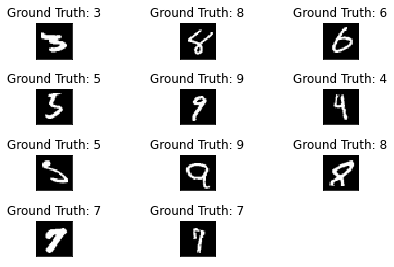

In [50]:
plot_figures(list_multiple_sol, all_pre, all_mean, all_var)

In [51]:
# Finding low probability and hight probability lists, top 9
std_sol_sorted = sorted(std_sol, reverse=True)
mean_sol_sorted = sorted(mean_sol, reverse=False)
mean_sol_sorted_index = []
std_sol_sorted_index = []
for i in range(9):
    mean_sol_sorted_index.append(mean_sol.index(mean_sol_sorted[i]))
    std_sol_sorted_index.append(std_sol.index(std_sol_sorted[i]))

In [52]:
# Only single predictions
mean_sol_sorted_index, std_sol_sorted_index

([147, 68, 73, 177, 131, 179, 61, 183, 197],
 [73, 68, 147, 179, 61, 148, 177, 66, 131])

~~~~~~~~~~~~~~~~~ Image 1 ~~~~~~~~~~~~~~~~~
predictions [4]  ground truth 4
mean: 0.7154167211055755
std: 0.07484985431523575
std/mean: 0.10462413318990625
~~~~~~~~~~~~~~~~~ Image 2 ~~~~~~~~~~~~~~~~~
predictions [8]  ground truth 3
mean: 0.7314767092466354
std: 0.0819943692961502
std/mean: 0.11209429946251886
~~~~~~~~~~~~~~~~~ Image 3 ~~~~~~~~~~~~~~~~~
predictions [8]  ground truth 8
mean: 0.8003557598590851
std: 0.08911817509932234
std/mean: 0.11134820234818195
~~~~~~~~~~~~~~~~~ Image 4 ~~~~~~~~~~~~~~~~~
predictions [9]  ground truth 9
mean: 0.8303099209070206
std: 0.056911570869774136
std/mean: 0.06854256397129956
~~~~~~~~~~~~~~~~~ Image 5 ~~~~~~~~~~~~~~~~~
predictions [2]  ground truth 2
mean: 0.8434383118152619
std: 0.05269654295744318
std/mean: 0.06247824199973654
~~~~~~~~~~~~~~~~~ Image 6 ~~~~~~~~~~~~~~~~~
predictions [5]  ground truth 5
mean: 0.8450044339895249
std: 0.0734621476367692
std/mean: 0.08693699663791335
~~~~~~~~~~~~~~~~~ Image 7 ~~~~~~~~~~~~~~~~~
predictions [9]  grou

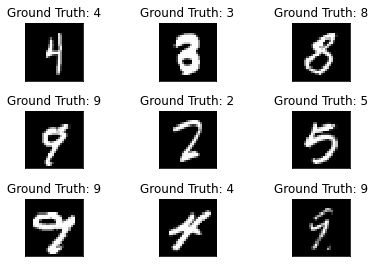

In [53]:
# Lowest mean to highest
plot_figures(mean_sol_sorted_index, all_pre, all_mean, all_var)

In [54]:
list_multiple_sol, std_sol_sorted_index

([3, 11, 22, 26, 45, 53, 65, 69, 126, 132, 150],
 [73, 68, 147, 179, 61, 148, 177, 66, 131])

~~~~~~~~~~~~~~~~~ Image 1 ~~~~~~~~~~~~~~~~~
predictions [8]  ground truth 8
mean: 0.8003557598590851
std: 0.08911817509932234
std/mean: 0.11134820234818195
~~~~~~~~~~~~~~~~~ Image 2 ~~~~~~~~~~~~~~~~~
predictions [8]  ground truth 3
mean: 0.7314767092466354
std: 0.0819943692961502
std/mean: 0.11209429946251886
~~~~~~~~~~~~~~~~~ Image 3 ~~~~~~~~~~~~~~~~~
predictions [4]  ground truth 4
mean: 0.7154167211055755
std: 0.07484985431523575
std/mean: 0.10462413318990625
~~~~~~~~~~~~~~~~~ Image 4 ~~~~~~~~~~~~~~~~~
predictions [5]  ground truth 5
mean: 0.8450044339895249
std: 0.0734621476367692
std/mean: 0.08693699663791335
~~~~~~~~~~~~~~~~~ Image 5 ~~~~~~~~~~~~~~~~~
predictions [9]  ground truth 9
mean: 0.8492548894882203
std: 0.06397472120273345
std/mean: 0.07533041257058412
~~~~~~~~~~~~~~~~~ Image 6 ~~~~~~~~~~~~~~~~~
predictions [0]  ground truth 2
mean: 0.8851133090257645
std: 0.06338345139729126
std/mean: 0.0716105505938633
~~~~~~~~~~~~~~~~~ Image 7 ~~~~~~~~~~~~~~~~~
predictions [9]  ground

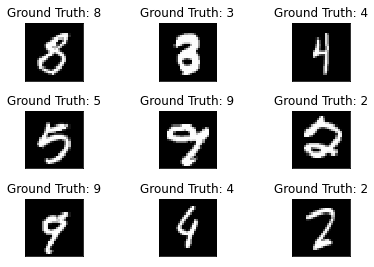

In [55]:
# Highest std to lowest
plot_figures(std_sol_sorted_index, all_pre, all_mean, all_var)
# Note that they have lower std than the multiple predictions list.

In [56]:
# Error

error_list = []
# prob_list2 = []
for i in range(200):
    output = model(example_data[i].unsqueeze(0))
    
    pred = output.data.max(1, keepdim=True)[1]
    if example_targets[i].unsqueeze(0).item() != pred.item():
        error_list.append(i)
#         prob_list2.append(F.softmax(output[0], dim=0).max(0)[0].item())
        
        
print(error_list)


<ipython-input-8-6c2218f37724>:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


[11, 65, 68, 141, 148, 193]


In [57]:
list_multiple_sol

[3, 11, 22, 26, 45, 53, 65, 69, 126, 132, 150]

In [58]:
num_mult_error = sum(el in list_multiple_sol for el in error_list)
print(num_mult_error, "of the", len(error_list), "errors are in list_multiple_sol")
print("which is:", num_mult_error/len(error_list))
print("The length of list_multiple_sol is:", len(list_multiple_sol), "which implies that", num_mult_error/len(list_multiple_sol))

2 of the 6 errors are in list_multiple_sol
which is: 0.3333333333333333
The length of list_multiple_sol is: 11 which implies that 0.18181818181818182


In [59]:
for i in error_list:
    if len(all_pre[i]) == 1:
        print("Image:", i, "mean:", all_mean[i], "std:", all_var[i])
        print("std/mean", all_var[i]/all_mean[i], "\n")

Image: 68 mean: 0.7314767092466354 std: 0.0819943692961502
std/mean 0.11209429946251886 

Image: 141 mean: 0.9534356087446213 std: 0.015976012296054956
std/mean 0.016756257212891812 

Image: 148 mean: 0.8851133090257645 std: 0.06338345139729126
std/mean 0.0716105505938633 

Image: 193 mean: 0.9784395122528076 std: 0.008133811349620696
std/mean 0.008313044646871432 



~~~~~~~~~~~~~~~~~ Image 1 ~~~~~~~~~~~~~~~~~
predictions [8, 4]  ground truth 8
mean: [0.4201117551326752, 0.504595045189515]
std: [0.13916439402656947, 0.1414813265385707]
std/mean: [0.3312556535882222, 0.2803858814852876]
~~~~~~~~~~~~~~~~~ Image 2 ~~~~~~~~~~~~~~~~~
predictions [8, 5, 6]  ground truth 5
mean: [0.20629814423620702, 0.26526927391551874, 0.24118995208081168]
std: [0.05238253570954325, 0.06344076123555628, 0.0644236790221118]
std/mean: [0.253916659810407, 0.23915608581098047, 0.26710764053938024]
~~~~~~~~~~~~~~~~~ Image 3 ~~~~~~~~~~~~~~~~~
predictions [8]  ground truth 3
mean: 0.7314767092466354
std: 0.0819943692961502
std/mean: 0.11209429946251886
~~~~~~~~~~~~~~~~~ Image 4 ~~~~~~~~~~~~~~~~~
predictions [4]  ground truth 9
mean: 0.9534356087446213
std: 0.015976012296054956
std/mean: 0.016756257212891812
~~~~~~~~~~~~~~~~~ Image 5 ~~~~~~~~~~~~~~~~~
predictions [0]  ground truth 2
mean: 0.8851133090257645
std: 0.06338345139729126
std/mean: 0.0716105505938633
~~~~~~~~~~~~~~~~~

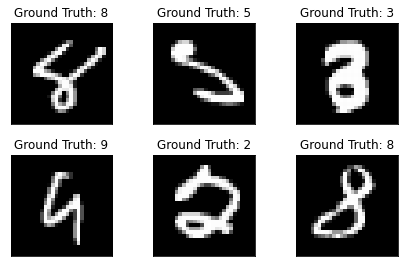

In [60]:
plot_figures(error_list, all_pre, all_mean, all_var)

In [61]:
num_prediction_counter = 0
correct_counter = 0
for i in range(len(all_pre)):
    if len(all_pre[i]) == 1:
        if all_var[i] <= 0.05:
            num_prediction_counter += 1
            if all_pre[i][0] == example_targets[i].item():
                correct_counter+=1
            else:
                print("i", i, "all_mean[i]", all_mean[i], "all_var[i]", all_var[i], "std/mean", all_var[i]/all_mean[i])

        
print("\nnum_prediction_counter", num_prediction_counter)
print("correct_counter", correct_counter)
print("precentage", correct_counter/num_prediction_counter)

i 141 all_mean[i] 0.9534356087446213 all_var[i] 0.015976012296054956 std/mean 0.016756257212891812
i 193 all_mean[i] 0.9784395122528076 all_var[i] 0.008133811349620696 std/mean 0.008313044646871432

num_prediction_counter 179
correct_counter 177
precentage 0.9888268156424581


In [62]:
num_prediction_counter = 0
correct_counter = 0
for i in range(len(all_pre)):
    if len(all_pre[i]) == 1:
        if all_mean[i] >= 0.85:
            num_prediction_counter += 1
            if all_pre[i][0] == example_targets[i].item():
                correct_counter+=1
            else:
                print("i", i, "all_mean[i]", all_mean[i], "all_var[i]", all_var[i], "std/mean", all_var[i]/all_mean[i])

        
print("\nnum_prediction_counter", num_prediction_counter)
print("correct_counter", correct_counter)
print("precentage", correct_counter/num_prediction_counter)

i 141 all_mean[i] 0.9534356087446213 all_var[i] 0.015976012296054956 std/mean 0.016756257212891812
i 148 all_mean[i] 0.8851133090257645 all_var[i] 0.06338345139729126 std/mean 0.0716105505938633
i 193 all_mean[i] 0.9784395122528076 all_var[i] 0.008133811349620696 std/mean 0.008313044646871432

num_prediction_counter 182
correct_counter 179
precentage 0.9835164835164835


In [63]:
num_prediction_counter = 0
correct_counter = 0
for i in range(len(all_pre)):
    if len(all_pre[i]) == 1:
        if (all_var[i]/all_mean[i]) <= 0.068:
            num_prediction_counter += 1
            if all_pre[i][0] == example_targets[i].item():
                correct_counter+=1
            else:
                print("i", i, "all_mean[i]", all_mean[i], "all_var[i]", all_var[i], "std/mean", all_var[i]/all_mean[i])
        
print("\nnum_prediction_counter", num_prediction_counter)
print("correct_counter", correct_counter)
print("precentage", correct_counter/num_prediction_counter)

i 141 all_mean[i] 0.9534356087446213 all_var[i] 0.015976012296054956 std/mean 0.016756257212891812
i 193 all_mean[i] 0.9784395122528076 all_var[i] 0.008133811349620696 std/mean 0.008313044646871432

num_prediction_counter 182
correct_counter 180
precentage 0.989010989010989


In [64]:
current_path = r'C:\Users\richa\Pictures\Saved Pictures\research'

In [65]:
current_path

'C:\\Users\\richa\\Pictures\\Saved Pictures\\research'

In [66]:
from  PIL import Image
import cv2
num_img = []
images = []
num_img.append(len(os.listdir(current_path)))
for filename in os.listdir(current_path):
    img = Image.open(os.path.join(current_path, filename))
    img = img.convert('1')
#     img.save('greyscale.png')
#     img = cv2.imwrite('myImage.png',img)
    if img is not None:
    
        images.append(img)

In [67]:
images, num_img

([<PIL.Image.Image image mode=1 size=1920x1080 at 0x249D73ADB50>], [1])

In [68]:
from torchvision import transforms
transform=torchvision.transforms.Compose([
                                transforms.Resize(28),
                                transforms.CenterCrop(28),
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])

In [69]:
from sklearn import preprocessing
list_input_tensor = []
list_input_batch = []
for item in range(1):
    input_tensor = transform(images[item])
    input_batch = input_tensor.unsqueeze(0)
    list_input_tensor.append(input_tensor)
    list_input_batch.append(input_batch)

In [70]:
input_batch.shape

torch.Size([1, 1, 28, 28])

In [71]:
example_data[0].shape

torch.Size([1, 28, 28])

In [253]:
predictions, prob_df = class_prob(input_batch[0].unsqueeze(0), 1000)
predictions

<ipython-input-8-6c2218f37724>:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


{0, 2, 3}

In [309]:
df_mean_std, df_mean, df_std = mean_std(prob_df)

In [310]:
for i in predictions:
    print("pre", i, "mean", df_mean[i], "std", df_std[i], "std/mean", df_std[i]/df_mean[i])


pre 0 mean 0.24536213626878028 std 0.020665701908594288 std/mean 0.08422530967025893
pre 2 mean 0.4497839583274736 std 0.02991625371386265 std/mean 0.06651249596607793
pre 3 mean 0.3775997192519741 std 0.027850549789916836 std/mean 0.07375680746026199


In [256]:
# for i in range(10):
#     print("pre", i, "mean", df_mean[i], "std", df_std[i], "std/mean", df_std[i]/df_mean[i])

In [274]:
df_mean, df_std

(0    0.129948
 1    0.087413
 2    0.222882
 3    0.190515
 4    0.042025
 5    0.058878
 6    0.035336
 7    0.143248
 8    0.042088
 9    0.047666
 Name: mean, dtype: float64,
 0    0.020063
 1    0.011761
 2    0.028414
 3    0.026746
 4    0.005851
 5    0.010921
 6    0.006530
 7    0.017015
 8    0.005521
 9    0.006889
 Name: std, dtype: float64)

In [258]:
200

11

5-mult pre
-> 6 single pre

SyntaxError: invalid syntax (<ipython-input-258-170f4be5ac97>, line 5)

In [259]:
# MCMC? 
# Insted of selecting the highest, 
# Confidence of the prediction

In [77]:
# Insted of choosing the image with the hiest proability, now it will seleted given their probability

In [275]:

df_mean.sample(weights=df_mean, n=2)

3    0.190515
7    0.143248
Name: mean, dtype: float64

In [312]:
predictions, prob_df = class_prob(example_data[0].unsqueeze(0), 1000)

<ipython-input-8-6c2218f37724>:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


In [313]:
df_mean_std, df_mean, df_std = mean_std(prob_df)

In [314]:
df_mean

0    3.179581e-05
1    1.790249e-07
2    3.037687e-06
3    4.890642e-06
4    1.825834e-07
5    5.334930e-07
6    1.007063e-10
7    9.972818e-01
8    2.938128e-06
9    2.674664e-03
Name: mean, dtype: float64

In [315]:
df_mean.sample(weights=df_mean, n=10)

7    9.972818e-01
9    2.674664e-03
0    3.179581e-05
3    4.890642e-06
8    2.938128e-06
2    3.037687e-06
4    1.825834e-07
5    5.334930e-07
1    1.790249e-07
6    1.007063e-10
Name: mean, dtype: float64

In [316]:
df_mean.sample(weights=df_mean, n=1, replace=True)

7    0.997282
Name: mean, dtype: float64

In [317]:
len(prob_df.columns)

1002

In [318]:
prob_df

,0,1,2,3,4,5,6,7,8,9,...,992,993,994,995,996,997,998,999,mean,std
0,5.786133e-05,1.680088e-05,1.843576e-05,4.676656e-05,2.486203e-05,1.312825e-05,5.217447e-05,3.276578e-05,1.397870e-05,7.624463e-06,...,1.330914e-05,1.505631e-05,2.093480e-05,7.249072e-05,4.098866e-05,7.077481e-05,3.535974e-05,8.735839e-06,3.179581e-05,2.110827e-05
1,2.009263e-07,5.542262e-08,7.492642e-08,3.452470e-07,1.275317e-07,7.933328e-08,1.528586e-07,2.379759e-07,1.159817e-07,1.052082e-07,...,4.251460e-08,1.510466e-07,1.937292e-07,2.944793e-07,1.670341e-07,2.128708e-07,1.434298e-07,2.043343e-07,1.790249e-07,1.303487e-07
2,2.360174e-06,1.469879e-06,1.216247e-06,4.527731e-06,1.508619e-06,1.841414e-06,3.082323e-06,5.322615e-06,1.981753e-06,2.069302e-06,...,9.068695e-07,2.763991e-06,2.090722e-06,5.006623e-06,3.191562e-06,4.122724e-06,2.658724e-06,2.693520e-06,3.037687e-06,2.110683e-06
3,5.659792e-06,3.245853e-06,2.512084e-06,6.345012e-06,2.567281e-06,1.955944e-06,4.887081e-06,4.614725e-06,2.623509e-06,3.136851e-06,...,1.304533e-06,1.026684e-05,2.908601e-06,1.093526e-05,3.110321e-06,8.947503e-06,4.051968e-06,3.556379e-06,4.890642e-06,2.945971e-06
4,1.375029e-07,1.298779e-07,9.395692e-08,1.682389e-07,1.111358e-07,7.068157e-08,3.698746e-07,1.267583e-07,6.818291e-08,3.781333e-08,...,4.970365e-08,1.270573e-07,1.429961e-07,1.263814e-07,8.393334e-08,1.323948e-07,2.508548e-07,1.420082e-07,1.825834e-07,1.324355e-07
5,1.226283e-06,6.136302e-07,4.104684e-07,6.487342e-07,3.192314e-07,1.905831e-07,4.307044e-07,1.402837e-07,5.042707e-07,8.048669e-08,...,1.227872e-07,2.619772e-07,5.385176e-07,4.291461e-07,3.318698e-07,6.180121e-07,9.507860e-07,3.665075e-07,5.334930e-07,3.779815e-07
6,1.939716e-10,4.610395e-11,3.435379e-11,1.580480e-10,6.396388e-11,4.501236e-11,6.885682e-11,7.121559e-11,4.027580e-11,6.389429e-12,...,1.010350e-11,5.167334e-11,6.110502e-11,1.562171e-10,6.866795e-11,1.217812e-10,1.012197e-10,4.482611e-11,1.007063e-10,9.693912e-11
7,9.973431e-01,9.979143e-01,9.969395e-01,9.934077e-01,9.989318e-01,9.984137e-01,9.963434e-01,9.983204e-01,9.979061e-01,9.990797e-01,...,9.987313e-01,9.978337e-01,9.962873e-01,9.962801e-01,9.978266e-01,9.972239e-01,9.971330e-01,9.985967e-01,9.972818e-01,1.380365e-03
8,4.203310e-06,2.068335e-06,1.466677e-06,2.917060e-06,1.566329e-06,1.492971e-06,3.020164e-06,3.198017e-06,2.581771e-06,1.433390e-06,...,4.584777e-07,4.474739e-06,2.817834e-06,2.434269e-06,2.693851e-06,4.446837e-06,7.217890e-06,2.789010e-06,2.938128e-06,1.861939e-06
9,2.585214e-03,2.061395e-03,3.036231e-03,6.530506e-03,1.037058e-03,1.567584e-03,3.592474e-03,1.633149e-03,2.072043e-03,9.057500e-04,...,1.252541e-03,2.133263e-03,3.683057e-03,3.628106e-03,2.122811e-03,2.686934e-03,2.816292e-03,1.384777e-03,2.674664e-03,1.368773e-03


In [349]:
def select_given_prob(df_prob, mean_var = False):
    df_copy = df_prob.copy()
    extra_columns = 0
    if mean_var:
        extra_columns = 2
        
    df_copy['count']= 0
    for i in range(len(df_copy.columns)-1-extra_columns):
        number_pre_data = df_copy.iloc[:, i].sample(weights=df_mean, n=1, replace=True)
        number_pre = number_pre_data.axes[0][0]
        df_copy['count'].iloc[number_pre] += 1
    
    num_pre = df_copy['count'].sum() 
    df_copy['ratio']= 0
    for i in range(10):
        df_copy['ratio'].iloc[i] = df_copy_count.iloc[i]/num_pre

    df_copy

    return df_copy, df_copy['count'], df_copy['ratio']
    
    

In [350]:
df_copy, df_copy_count, df_copy_ratio = select_given_prob(prob_df, True)

C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

In [351]:
df_copy

,0,1,2,3,4,5,6,7,8,9,...,994,995,996,997,998,999,mean,std,count,ratio
0,5.786133e-05,1.680088e-05,1.843576e-05,4.676656e-05,2.486203e-05,1.312825e-05,5.217447e-05,3.276578e-05,1.397870e-05,7.624463e-06,...,2.093480e-05,7.249072e-05,4.098866e-05,7.077481e-05,3.535974e-05,8.735839e-06,3.179581e-05,2.110827e-05,1,0.000
1,2.009263e-07,5.542262e-08,7.492642e-08,3.452470e-07,1.275317e-07,7.933328e-08,1.528586e-07,2.379759e-07,1.159817e-07,1.052082e-07,...,1.937292e-07,2.944793e-07,1.670341e-07,2.128708e-07,1.434298e-07,2.043343e-07,1.790249e-07,1.303487e-07,0,0.000
2,2.360174e-06,1.469879e-06,1.216247e-06,4.527731e-06,1.508619e-06,1.841414e-06,3.082323e-06,5.322615e-06,1.981753e-06,2.069302e-06,...,2.090722e-06,5.006623e-06,3.191562e-06,4.122724e-06,2.658724e-06,2.693520e-06,3.037687e-06,2.110683e-06,0,0.000
3,5.659792e-06,3.245853e-06,2.512084e-06,6.345012e-06,2.567281e-06,1.955944e-06,4.887081e-06,4.614725e-06,2.623509e-06,3.136851e-06,...,2.908601e-06,1.093526e-05,3.110321e-06,8.947503e-06,4.051968e-06,3.556379e-06,4.890642e-06,2.945971e-06,0,0.000
4,1.375029e-07,1.298779e-07,9.395692e-08,1.682389e-07,1.111358e-07,7.068157e-08,3.698746e-07,1.267583e-07,6.818291e-08,3.781333e-08,...,1.429961e-07,1.263814e-07,8.393334e-08,1.323948e-07,2.508548e-07,1.420082e-07,1.825834e-07,1.324355e-07,0,0.000
5,1.226283e-06,6.136302e-07,4.104684e-07,6.487342e-07,3.192314e-07,1.905831e-07,4.307044e-07,1.402837e-07,5.042707e-07,8.048669e-08,...,5.385176e-07,4.291461e-07,3.318698e-07,6.180121e-07,9.507860e-07,3.665075e-07,5.334930e-07,3.779815e-07,0,0.000
6,1.939716e-10,4.610395e-11,3.435379e-11,1.580480e-10,6.396388e-11,4.501236e-11,6.885682e-11,7.121559e-11,4.027580e-11,6.389429e-12,...,6.110502e-11,1.562171e-10,6.866795e-11,1.217812e-10,1.012197e-10,4.482611e-11,1.007063e-10,9.693912e-11,0,0.000
7,9.973431e-01,9.979143e-01,9.969395e-01,9.934077e-01,9.989318e-01,9.984137e-01,9.963434e-01,9.983204e-01,9.979061e-01,9.990797e-01,...,9.962873e-01,9.962801e-01,9.978266e-01,9.972239e-01,9.971330e-01,9.985967e-01,9.972818e-01,1.380365e-03,998,0.998
8,4.203310e-06,2.068335e-06,1.466677e-06,2.917060e-06,1.566329e-06,1.492971e-06,3.020164e-06,3.198017e-06,2.581771e-06,1.433390e-06,...,2.817834e-06,2.434269e-06,2.693851e-06,4.446837e-06,7.217890e-06,2.789010e-06,2.938128e-06,1.861939e-06,0,0.000
9,2.585214e-03,2.061395e-03,3.036231e-03,6.530506e-03,1.037058e-03,1.567584e-03,3.592474e-03,1.633149e-03,2.072043e-03,9.057500e-04,...,3.683057e-03,3.628106e-03,2.122811e-03,2.686934e-03,2.816292e-03,1.384777e-03,2.674664e-03,1.368773e-03,1,0.002


In [347]:
df_copy_count.iloc[3]

0

In [339]:
df_copy

,0,1,2,3,4,5,6,7,8,9,...,993,994,995,996,997,998,999,mean,std,count
0,5.786133e-05,1.680088e-05,1.843576e-05,4.676656e-05,2.486203e-05,1.312825e-05,5.217447e-05,3.276578e-05,1.397870e-05,7.624463e-06,...,1.505631e-05,2.093480e-05,7.249072e-05,4.098866e-05,7.077481e-05,3.535974e-05,8.735839e-06,3.179581e-05,2.110827e-05,0
1,2.009263e-07,5.542262e-08,7.492642e-08,3.452470e-07,1.275317e-07,7.933328e-08,1.528586e-07,2.379759e-07,1.159817e-07,1.052082e-07,...,1.510466e-07,1.937292e-07,2.944793e-07,1.670341e-07,2.128708e-07,1.434298e-07,2.043343e-07,1.790249e-07,1.303487e-07,0
2,2.360174e-06,1.469879e-06,1.216247e-06,4.527731e-06,1.508619e-06,1.841414e-06,3.082323e-06,5.322615e-06,1.981753e-06,2.069302e-06,...,2.763991e-06,2.090722e-06,5.006623e-06,3.191562e-06,4.122724e-06,2.658724e-06,2.693520e-06,3.037687e-06,2.110683e-06,0
3,5.659792e-06,3.245853e-06,2.512084e-06,6.345012e-06,2.567281e-06,1.955944e-06,4.887081e-06,4.614725e-06,2.623509e-06,3.136851e-06,...,1.026684e-05,2.908601e-06,1.093526e-05,3.110321e-06,8.947503e-06,4.051968e-06,3.556379e-06,4.890642e-06,2.945971e-06,0
4,1.375029e-07,1.298779e-07,9.395692e-08,1.682389e-07,1.111358e-07,7.068157e-08,3.698746e-07,1.267583e-07,6.818291e-08,3.781333e-08,...,1.270573e-07,1.429961e-07,1.263814e-07,8.393334e-08,1.323948e-07,2.508548e-07,1.420082e-07,1.825834e-07,1.324355e-07,0
5,1.226283e-06,6.136302e-07,4.104684e-07,6.487342e-07,3.192314e-07,1.905831e-07,4.307044e-07,1.402837e-07,5.042707e-07,8.048669e-08,...,2.619772e-07,5.385176e-07,4.291461e-07,3.318698e-07,6.180121e-07,9.507860e-07,3.665075e-07,5.334930e-07,3.779815e-07,0
6,1.939716e-10,4.610395e-11,3.435379e-11,1.580480e-10,6.396388e-11,4.501236e-11,6.885682e-11,7.121559e-11,4.027580e-11,6.389429e-12,...,5.167334e-11,6.110502e-11,1.562171e-10,6.866795e-11,1.217812e-10,1.012197e-10,4.482611e-11,1.007063e-10,9.693912e-11,0
7,9.973431e-01,9.979143e-01,9.969395e-01,9.934077e-01,9.989318e-01,9.984137e-01,9.963434e-01,9.983204e-01,9.979061e-01,9.990797e-01,...,9.978337e-01,9.962873e-01,9.962801e-01,9.978266e-01,9.972239e-01,9.971330e-01,9.985967e-01,9.972818e-01,1.380365e-03,998
8,4.203310e-06,2.068335e-06,1.466677e-06,2.917060e-06,1.566329e-06,1.492971e-06,3.020164e-06,3.198017e-06,2.581771e-06,1.433390e-06,...,4.474739e-06,2.817834e-06,2.434269e-06,2.693851e-06,4.446837e-06,7.217890e-06,2.789010e-06,2.938128e-06,1.861939e-06,0
9,2.585214e-03,2.061395e-03,3.036231e-03,6.530506e-03,1.037058e-03,1.567584e-03,3.592474e-03,1.633149e-03,2.072043e-03,9.057500e-04,...,2.133263e-03,3.683057e-03,3.628106e-03,2.122811e-03,2.686934e-03,2.816292e-03,1.384777e-03,2.674664e-03,1.368773e-03,2


In [348]:
num_pre = df_copy['count'].sum() 
df_copy['ratio']= 0
for i in range(10):
    df_copy['ratio'].iloc[i] = df_copy_count.iloc[i]/num_pre
    
df_copy

C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,0,1,2,3,4,5,6,7,8,9,...,994,995,996,997,998,999,mean,std,count,ratio
0,5.786133e-05,1.680088e-05,1.843576e-05,4.676656e-05,2.486203e-05,1.312825e-05,5.217447e-05,3.276578e-05,1.397870e-05,7.624463e-06,...,2.093480e-05,7.249072e-05,4.098866e-05,7.077481e-05,3.535974e-05,8.735839e-06,3.179581e-05,2.110827e-05,0,0.000
1,2.009263e-07,5.542262e-08,7.492642e-08,3.452470e-07,1.275317e-07,7.933328e-08,1.528586e-07,2.379759e-07,1.159817e-07,1.052082e-07,...,1.937292e-07,2.944793e-07,1.670341e-07,2.128708e-07,1.434298e-07,2.043343e-07,1.790249e-07,1.303487e-07,0,0.000
2,2.360174e-06,1.469879e-06,1.216247e-06,4.527731e-06,1.508619e-06,1.841414e-06,3.082323e-06,5.322615e-06,1.981753e-06,2.069302e-06,...,2.090722e-06,5.006623e-06,3.191562e-06,4.122724e-06,2.658724e-06,2.693520e-06,3.037687e-06,2.110683e-06,0,0.000
3,5.659792e-06,3.245853e-06,2.512084e-06,6.345012e-06,2.567281e-06,1.955944e-06,4.887081e-06,4.614725e-06,2.623509e-06,3.136851e-06,...,2.908601e-06,1.093526e-05,3.110321e-06,8.947503e-06,4.051968e-06,3.556379e-06,4.890642e-06,2.945971e-06,0,0.000
4,1.375029e-07,1.298779e-07,9.395692e-08,1.682389e-07,1.111358e-07,7.068157e-08,3.698746e-07,1.267583e-07,6.818291e-08,3.781333e-08,...,1.429961e-07,1.263814e-07,8.393334e-08,1.323948e-07,2.508548e-07,1.420082e-07,1.825834e-07,1.324355e-07,0,0.000
5,1.226283e-06,6.136302e-07,4.104684e-07,6.487342e-07,3.192314e-07,1.905831e-07,4.307044e-07,1.402837e-07,5.042707e-07,8.048669e-08,...,5.385176e-07,4.291461e-07,3.318698e-07,6.180121e-07,9.507860e-07,3.665075e-07,5.334930e-07,3.779815e-07,0,0.000
6,1.939716e-10,4.610395e-11,3.435379e-11,1.580480e-10,6.396388e-11,4.501236e-11,6.885682e-11,7.121559e-11,4.027580e-11,6.389429e-12,...,6.110502e-11,1.562171e-10,6.866795e-11,1.217812e-10,1.012197e-10,4.482611e-11,1.007063e-10,9.693912e-11,0,0.000
7,9.973431e-01,9.979143e-01,9.969395e-01,9.934077e-01,9.989318e-01,9.984137e-01,9.963434e-01,9.983204e-01,9.979061e-01,9.990797e-01,...,9.962873e-01,9.962801e-01,9.978266e-01,9.972239e-01,9.971330e-01,9.985967e-01,9.972818e-01,1.380365e-03,998,0.998
8,4.203310e-06,2.068335e-06,1.466677e-06,2.917060e-06,1.566329e-06,1.492971e-06,3.020164e-06,3.198017e-06,2.581771e-06,1.433390e-06,...,2.817834e-06,2.434269e-06,2.693851e-06,4.446837e-06,7.217890e-06,2.789010e-06,2.938128e-06,1.861939e-06,0,0.000
9,2.585214e-03,2.061395e-03,3.036231e-03,6.530506e-03,1.037058e-03,1.567584e-03,3.592474e-03,1.633149e-03,2.072043e-03,9.057500e-04,...,3.683057e-03,3.628106e-03,2.122811e-03,2.686934e-03,2.816292e-03,1.384777e-03,2.674664e-03,1.368773e-03,2,0.002


In [296]:
from numpy.random import randint
prob_df['count']= 0

In [297]:
prob_df['count'].iloc[3] += 4

C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [298]:
prob_df

,0,1,2,3,4,5,6,7,8,9,...,993,994,995,996,997,998,999,mean,std,count
0,0.130911,0.142219,0.100141,0.138963,0.178014,0.102269,0.130821,0.212237,0.126294,0.117447,...,0.119132,0.167600,0.137392,0.108345,0.133773,0.128730,0.129042,0.129948,0.020063,0
1,0.103097,0.083120,0.089822,0.082840,0.061957,0.086554,0.086526,0.065816,0.083830,0.080343,...,0.087048,0.076157,0.093241,0.094716,0.082594,0.086262,0.089363,0.087413,0.011761,0
2,0.277607,0.236581,0.224060,0.251009,0.153469,0.263393,0.182760,0.233874,0.299642,0.302925,...,0.187143,0.228817,0.220027,0.213651,0.225980,0.215116,0.192828,0.222882,0.028414,0
3,0.146723,0.186218,0.211143,0.177288,0.198238,0.217215,0.205661,0.138318,0.179516,0.162538,...,0.199526,0.172156,0.150902,0.196476,0.207280,0.192228,0.177791,0.190515,0.026746,4
4,0.043442,0.038655,0.040615,0.040204,0.042034,0.038904,0.044831,0.037552,0.036126,0.047026,...,0.043149,0.034245,0.051814,0.043928,0.033060,0.045778,0.045317,0.042025,0.005851,0
5,0.053583,0.050095,0.052643,0.048457,0.091790,0.043464,0.066651,0.057342,0.039951,0.046624,...,0.075636,0.052358,0.067265,0.052902,0.054592,0.069570,0.064493,0.058878,0.010921,0
6,0.037714,0.036856,0.027726,0.034086,0.036261,0.026254,0.035831,0.041264,0.028064,0.039638,...,0.036502,0.037466,0.043578,0.026574,0.033638,0.036047,0.032772,0.035336,0.006530,0
7,0.130618,0.133070,0.168251,0.127187,0.132426,0.151473,0.148345,0.126536,0.131262,0.132068,...,0.154356,0.146254,0.139123,0.173832,0.149183,0.133001,0.162112,0.143248,0.017015,0
8,0.036577,0.048571,0.037790,0.050588,0.047300,0.031294,0.038768,0.039298,0.037601,0.042047,...,0.041325,0.038816,0.043109,0.041961,0.040216,0.047397,0.037902,0.042088,0.005521,0
9,0.039728,0.044616,0.047810,0.049378,0.058511,0.039179,0.059806,0.047762,0.037715,0.029344,...,0.056183,0.046131,0.053550,0.047616,0.039684,0.045871,0.068379,0.047666,0.006889,0


In [ ]:
def pre_test_data(data, pred_fun)
pre = []
list_multiple_sol = []
multiple_predictions_list = []

std_sol = []
std_multiple_sol = []

mean_sol = []
mean_multiple_sol = []

all_pre =[]
all_mean =[]
all_var =[]
for i in range(200):
    
    predictions, prob_df = class_prob(example_data[i].unsqueeze(0), 100)
    predictions_list = list(predictions)
    
    if len(predictions_list)>1:
        print("multiple solutions in", i)
        list_multiple_sol.append(i)
        multiple_predictions_list.append(predictions_list)
        all_pre.append(predictions_list)
        
        std_sol.append(0)
        mean_sol.append(10)
        pre.append(10)
        
        std_saver = []
        mean_saver = []
        for m in predictions_list:
            df_mean_std, df_mean, df_std = mean_std(prob_df)
            std_saver.append(df_std[m])
            mean_saver.append(df_mean[m])
        std_multiple_sol.append(std_saver)
        mean_multiple_sol.append(mean_saver)
        
        all_var.append(std_saver)
        all_mean.append(mean_saver)
    else:
        
        df_mean_std, df_mean, df_std = mean_std(prob_df)
        std_sol.append(df_std[predictions_list[0]])
        mean_sol.append(df_mean[predictions_list[0]])
        pre.append(predictions_list[0])
        
        all_var.append(df_std[predictions_list[0]])
        all_mean.append(df_mean[predictions_list[0]])
        all_pre.append(predictions_list)
